In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import json
from time import time
import pickle
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Dropout,Embedding,LSTM,Dense
from keras.utils import to_categorical
from keras.layers.merge import add
import re

import cv2
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions = readTextFile("./Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [ ]:
print(len(captions))

40460


In [ ]:
first,second = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
descriptions = {}

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

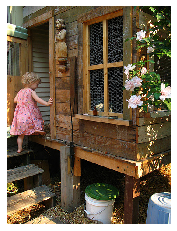

In [ ]:
IMG_PATH = "Flickr_Data/Images/"

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [ ]:
# + is for subsequent term to remove
t= "A cat is sitting over the house # 64"
t=t.lower()
d = re.sub("[^a-z]","/",t)
t = re.sub("[^a-z]+","/",t)

In [ ]:
print(d)
print(t)

a/cat/is/sitting/over/the/house/////
a/cat/is/sitting/over/the/house/


In [ ]:
# cleaning all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()
    
json_accepted_string = descriptions.replace("'","\"")
descriptions = json.loads(json_accepted_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [ ]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("total Wrods %d"%len(total_words))

total Wrods 373837


In [ ]:
import collections

counter = collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt))

8424


In [ ]:
sorted_frq_cnt = sorted(freq_cnt.items(),reverse=True,key = lambda x:x[1])

threshold = 10
sorted_frq_cnt = [x for x in sorted_frq_cnt if x[1] > threshold]
total_words = [x[0] for x in sorted_frq_cnt]

In [ ]:
print(len(total_words))

1845


In [ ]:
train_file = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file = readTextFile("Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file.split("\n")[:-1]]

In [ ]:
print(len(train))
print(len(test))

6000


1000

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
train_description = {}

for img_id in train:
    train_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "+ cap + " endseq"
        train_description[img_id].append(cap_to_append)

In [ ]:
train_description["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 25s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_______________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


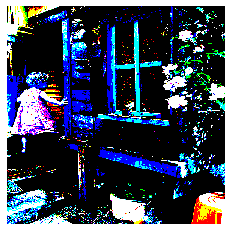

(1, 224, 224, 3)


In [ ]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
print(img.shape)

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.041543  , 0.17076081, 0.292786  , ..., 0.05089618, 0.3132235 ,
       0.8600756 ], dtype=float32)

In [ ]:
start = time()
encoding_train = {}

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100 == 0:
        print("Encoding in progress Time step %d "%ix)
    
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in progress Time step 0 
Encoding in progress Time step 100 
Encoding in progress Time step 200 
Encoding in progress Time step 300 
Encoding in progress Time step 400 
Encoding in progress Time step 500 
Encoding in progress Time step 600 
Encoding in progress Time step 700 
Encoding in progress Time step 800 
Encoding in progress Time step 900 
Encoding in progress Time step 1000 
Encoding in progress Time step 1100 
Encoding in progress Time step 1200 
Encoding in progress Time step 1300 
Encoding in progress Time step 1400 
Encoding in progress Time step 1500 
Encoding in progress Time step 1600 
Encoding in progress Time step 1700 
Encoding in progress Time step 1800 
Encoding in progress Time step 1900 
Encoding in progress Time step 2000 
Encoding in progress Time step 2100 
Encoding in progress Time step 2200 
Encoding in progress Time step 2300 
Encoding in progress Time step 2400 
Encoding in progress Time step 2500 
Encoding in progress Time step 2600 
Encoding in p

In [ ]:
#!mkdir saved     #already maded this

In [ ]:
len(encoding_train)

6000

In [ ]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
tart = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 9349.782191753387


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
len(encoding_test)

1000

In [ ]:
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(len(idx_to_word))
print(len(word_to_idx))


1845
1845


In [ ]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("vocab size",vocab_size)

vocab size 1848


In [ ]:
with open("saved/word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx,w2i)
with open("saved/idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word,i2w)
with open("saved/train_description.pkl","wb") as tdes:
    pickle.dump(train_description,tdes)

# now using google colab for further process

## loading data in google colab

In [2]:
!wget https://www.dropbox.com/s/aplpec1zsfe1oia/saved.zip?dl=0 -O sav

--2020-07-30 13:20:29--  https://www.dropbox.com/s/aplpec1zsfe1oia/saved.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/aplpec1zsfe1oia/saved.zip [following]
--2020-07-30 13:20:30--  https://www.dropbox.com/s/raw/aplpec1zsfe1oia/saved.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc75aad9ee9a0e1c4dba3f76c674.dl.dropboxusercontent.com/cd/0/inline/A8iwPNY6dsgAqZUW7tS9oQTy9Exa4p9jReezKQbZT3R1xoa5AEqflsQe-0QIxT6HlcrlA6D2i2N6W2CzyRWqEaBrJxQhz3j4p1nbqcF9xVu8K-eESFJrgRRxD_tD8mgzKbw/file# [following]
--2020-07-30 13:20:30--  https://uc75aad9ee9a0e1c4dba3f76c674.dl.dropboxusercontent.com/cd/0/inline/A8iwPNY6dsgAqZUW7tS9oQTy9Exa4p9jReezKQbZT3R1xoa5AEqflsQe-0QIxT6HlcrlA6D2i2N6W2CzyRWqEaBrJxQhz3j4p1nbqcF9xVu8K-eESFJ

In [3]:
!unzip sav -d saved/

Archive:  sav
  inflating: saved/encoded_test_features.pkl  
  inflating: saved/encoded_train_features.pkl  
  inflating: saved/idx_to_word.pkl   
  inflating: saved/train_description.pkl  
  inflating: saved/word_to_idx.pkl   


In [4]:
with open("saved/word_to_idx.pkl","rb") as w2i:
    word_to_idx=pickle.load(w2i)
with open("saved/idx_to_word.pkl","rb") as i2w:
    idx_to_word=pickle.load(i2w)
with open("saved/encoded_train_features.pkl","rb") as et:
    encoding_train=pickle.load(et)
with open("saved/encoded_test_features.pkl","rb") as etest:
    encoding_test=pickle.load(etest)
with open("saved/train_description.pkl","rb") as td:
    train_description=pickle.load(td)

In [5]:
vocab_size = len(word_to_idx) + 1
print("vocab size",vocab_size)

vocab size 1848


In [6]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [7]:
seq="is there"
print(word_to_idx['there'])
seq = [word_to_idx[word] for word in seq.split() if word in word_to_idx]
print(type(seq))
print(seq)
x = pad_sequences([seq],maxlen=5,value=0,padding='post')
print(x)
print(type(x))
print(x[0])

185
<class 'list'>
[4, 185]
[[  4 185   0   0   0]]
<class 'numpy.ndarray'>
[  4 185   0   0   0]


In [8]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
  x1,x2,y = [],[],[]

  n=0
  while True:
    for key,desc_list in train_description.items():
      n+=1

      photo = encoding_train[key]

      for desc in desc_list:

        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]

        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi = to_categorical([yi],num_classes=vocab_size)[0]

          x1.append(photo)
          x2.append(xi)
          y.append(yi)

        if n == batch_size:
          yield[[np.array(x1),np.array(x2)],np.array(y)]
          x1,x2,y = [],[],[]
          n=0

In [9]:
!wget https://www.dropbox.com/s/wxtd7oq8p6kzypm/glove.6B.50d.txt?dl=0 -O glove.txt

--2020-07-30 13:20:43--  https://www.dropbox.com/s/wxtd7oq8p6kzypm/glove.6B.50d.txt?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wxtd7oq8p6kzypm/glove.6B.50d.txt [following]
--2020-07-30 13:20:43--  https://www.dropbox.com/s/raw/wxtd7oq8p6kzypm/glove.6B.50d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8bb1527306ce3831f84897ff25.dl.dropboxusercontent.com/cd/0/inline/A8gd1f_C0pjTmcNWWW5aFx8rHC0xnzaZ4OLlP_BkQi0htleJuqyOeRTQ-AonU0rpOk-SC7BAjGgt5Wd4DhB1VWipV0LwQXqvgXDZsCLFf2d3NW_EJNyYW0FHNMt-CTf_N-M/file# [following]
--2020-07-30 13:20:44--  https://uc8bb1527306ce3831f84897ff25.dl.dropboxusercontent.com/cd/0/inline/A8gd1f_C0pjTmcNWWW5aFx8rHC0xnzaZ4OLlP_BkQi0htleJuqyOeRTQ-AonU0rpOk-SC7BAjGgt5Wd4DhB1VWipV0LwQX

In [10]:
f = open("glove.txt",encoding='utf8')

In [11]:
embedding_index = {}

for line in f:
  values = line.split()
  word = values[0]

  word_embedding = np.array(values[1:],dtype='float')
  embedding_index[word] = word_embedding

In [12]:
f.close()

In [13]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [14]:
def get_embedding_matrix():
  emb_dim = 50
  matrix = np.zeros((vocab_size,emb_dim))

  for word,idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
      matrix[idx] = embedding_vector
  return matrix

In [15]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [16]:
print(embedding_matrix)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.33042   0.24995  -0.60874  ... -0.50703  -0.027273 -0.53285 ]
 [ 0.418     0.24968  -0.41242  ... -0.18411  -0.11514  -0.78581 ]
 ...
 [-0.34126  -0.06117   0.93339  ... -0.5682   -0.6244    0.30874 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


In [17]:
(max_len)

35

In [18]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [19]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [20]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


In [21]:
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [22]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [24]:
7//2

3

In [25]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size
def train():
  for i in range(epochs):
    generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./saved/model_'+str(i)+'.h5')

In [26]:
train()

Epoch 1/1
2000/2000 [==============================] - 315s 157ms/step - loss: 4.2974
Epoch 1/1
2000/2000 [==============================] - 310s 155ms/step - loss: 3.5816
Epoch 1/1
2000/2000 [==============================] - 309s 155ms/step - loss: 3.3267
Epoch 1/1
2000/2000 [==============================] - 315s 157ms/step - loss: 3.1706
Epoch 1/1
2000/2000 [==============================] - 313s 156ms/step - loss: 3.0605
Epoch 1/1
2000/2000 [==============================] - 308s 154ms/step - loss: 2.9733
Epoch 1/1
2000/2000 [==============================] - 308s 154ms/step - loss: 2.9091
Epoch 1/1
2000/2000 [==============================] - 310s 155ms/step - loss: 2.8525
Epoch 1/1
2000/2000 [==============================] - 310s 155ms/step - loss: 2.8080
Epoch 1/1
2000/2000 [==============================] - 303s 151ms/step - loss: 2.7696
Epoch 1/1
2000/2000 [==============================] - 304s 152ms/step - loss: 2.7339
Epoch 1/1
2000/2000 [==============================] -

## only downlaoding last 3 model wights

# back to ljupyter notebook

In [2]:
with open("saved/word_to_idx.pkl","rb") as w2i:
    word_to_idx=pickle.load(w2i)
with open("saved/idx_to_word.pkl","rb") as i2w:
    idx_to_word=pickle.load(i2w)
with open("saved/encoded_train_features.pkl","rb") as et:
    encoding_train=pickle.load(et)
with open("saved/encoded_test_features.pkl","rb") as etest:
    encoding_test=pickle.load(etest)
with open("saved/train_description.pkl","rb") as td:
    train_description=pickle.load(td)

In [3]:
max_len = 0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [4]:
model = load_model('./saved/model_19.h5')

In [9]:
def predict_caption(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        y_pred = model.predict([photo,sequence])
        y_pred = y_pred.argmax()
        word = idx_to_word[y_pred]
        in_text+=(' '+word)

        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

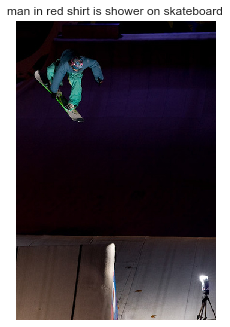

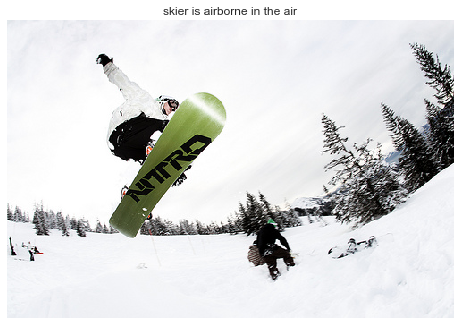

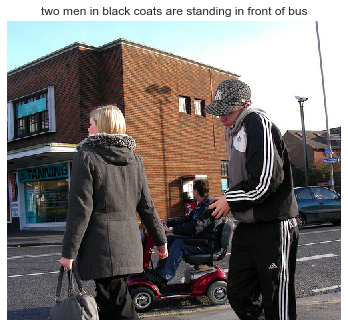

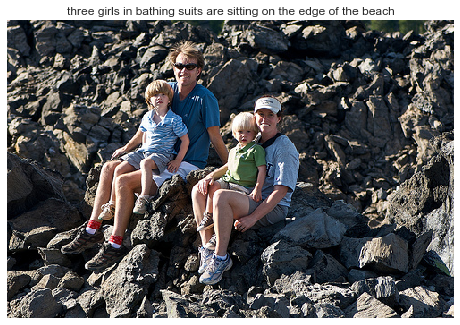

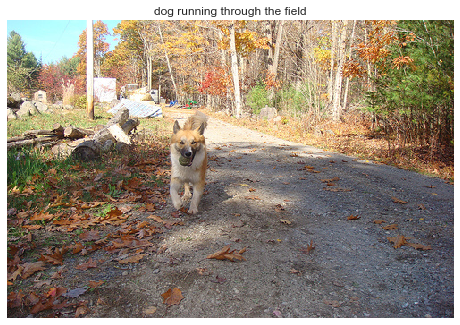

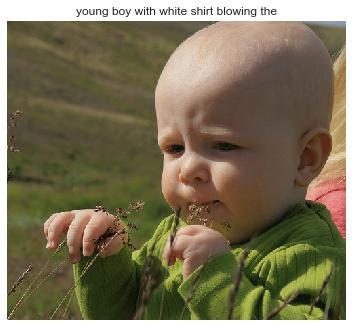

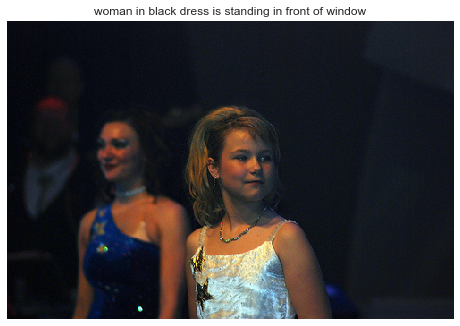

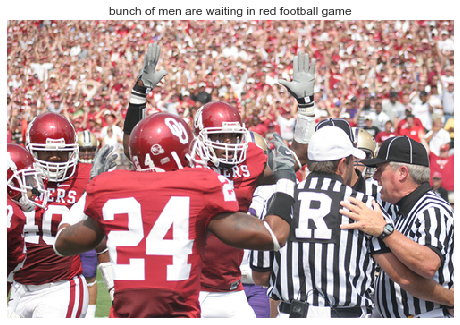

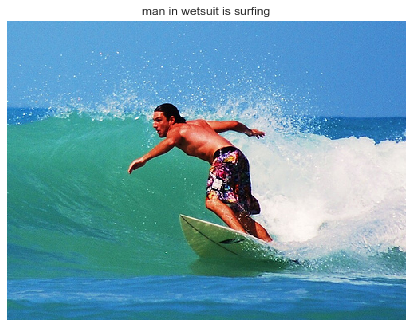

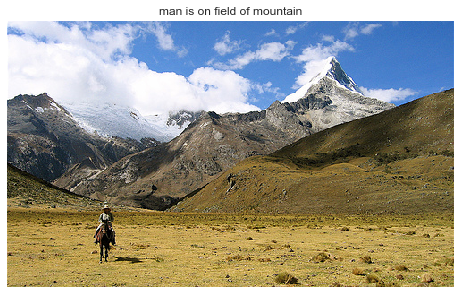

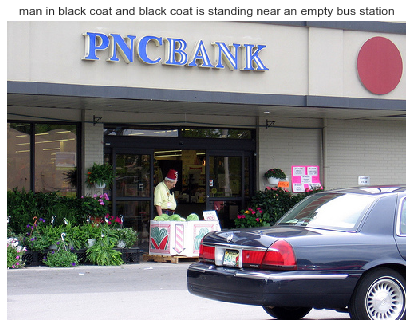

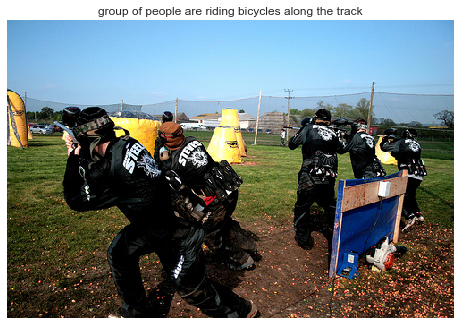

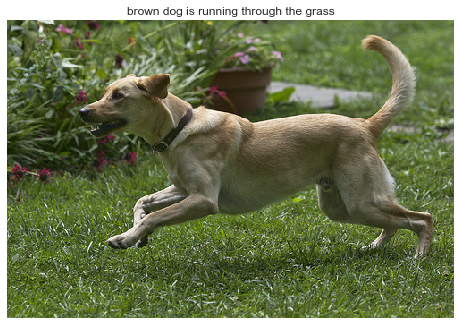

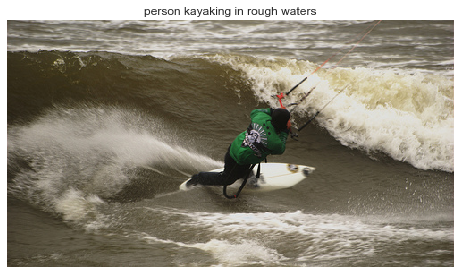

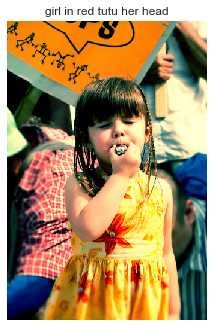

In [10]:
plt.style.use('seaborn')
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))

    i=plt.imread("Flickr_Data/Images/"+img_name+".jpg")

    caption = predict_caption(photo_2048)
  
    plt.title(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()